<b>¡Hola Lucia!</b>

Mi nombre es Alejandro Abia y tengo el gusto de revisar tu proyecto.

A continuación, encontrarás mis comentarios en celdas pintadas de tres colores (verde, amarillo y rojo), a manera de semáforo. Por favor, <b>no las borres ni muevas de posición</b> mientras dure el proceso de revisión.

<div class="alert alert-block alert-success">
<b>Éxito</b> <a class="tocSkip"></a>
En celdas verdes encontrarás comentarios en relación a tus aciertos y fortalezas.
</div>
<div class="alert alert-block alert-warning">
<b>Atención</b> <a class="tocSkip"></a>
Utilizaré el color amarillo para llamar tu atención, expresar algo importante o compartirte alguna idea de valor.
</div>
<div class="alert alert-block alert-danger">
<b>A resolver</b> <a class="tocSkip"></a>
En rojo emitiré aquellos puntos que podrían impedir que el proyecto se ejecute correctamente. No son errores, sino oportunidades importantes de mejora.
</div>
<div class="alert alert-block alert-info">
<b>Comentario estudiante</b> <a class="tocSkip"></a>
Si durante la revisión deseas dejarme algún comentario, por favor utiliza celdas azules como esta.
</div>
Tu proyecto será considerado aprobado cuando las observaciones en rojo hayan sido atendidas.  
¡Empecemos!


**Sprint 10 - Proyecto**

In [1]:
import os, re
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from textwrap import shorten
#Limpieza y uniformizacion de datos
def _norm(s: str) -> str:
    """Normaliza texto: minúsculas, sin acentos/espacios/símbolos."""
    s = str(s).strip().lower()
    s = (s
         .replace("á","a").replace("é","e").replace("í","i")
         .replace("ó","o").replace("ú","u").replace("ñ","n"))
    s = re.sub(r"[^a-z0-9]", "", s)
    return s

def _read_csv_robusto(paths, seps=(None,";",","), headers=(0,)):
    """Intenta leer CSV probando varias rutas, separadores y filas de encabezado."""
    last_err = None
    for p in paths:
        if not Path(p).exists():
            continue

        for sep in seps:
            for hdr in headers:
                try:
                    df = pd.read_csv(p, sep=sep, engine="python", encoding="utf-8-sig", header=hdr)
                    return df, p, sep, hdr
                except Exception as e:
                    last_err = e
    if last_err is None:
        raise FileNotFoundError(f"No se encontró el archivo en: {paths}")
    raise last_err

def _rename_columns(df, mapping):
    """Renombra columnas usando normalización + mapa de equivalencias."""
    rename_dict = {}
    for c in df.columns:
        key = _norm(c)
        if key in mapping:
            rename_dict[c] = mapping[key]
    return df.rename(columns=rename_dict)

def abrevia(s, n=70):
    """Acorta texto largo para una impresión más prolija en consola."""
    return shorten(str(s), width=n, placeholder="…")


<div class="alert alert-block alert-success">
<b>Celda [1]</b> <a class="tocSkip"></a><br>
Has logrado definir funciones robustas para la normalización de texto y la lectura de archivos CSV, lo cual es esencial para asegurar la consistencia de los datos y la flexibilidad del proceso de carga. Esto es crucial para manejar diferentes formatos de archivo de manera eficiente.
</div>



**PARTE 1. Priorizar hipótesis**


In [2]:
#Configuracion esperada para la Hypotesis
EXPECTED_MAP_HYP = {
    "hypothesis": "Hypothesis", "hypotheses": "Hypothesis", "hipotesis": "Hypothesis", "idea": "Hypothesis",
    "reach": "Reach", "alcance": "Reach",
    "impact": "Impact", "impacto": "Impact",
    "confidence": "Confidence", "confianza": "Confidence",
    "effort": "Effort", "esfuerzo": "Effort",
}
REQUIRED_HYP = {"Hypothesis", "Reach", "Impact", "Confidence", "Effort"}
HYP_PATHS = ["/datasets/hypotheses_us.csv", "datasets/hypotheses_us.csv", "hypotheses_us.csv"]

#Carga, normalizacion y limpieza de datos
df_hyp, used_path, used_sep, used_hdr = _read_csv_robusto(HYP_PATHS, seps=(None,";",","), headers=(0,1))
df_hyp = _rename_columns(df_hyp, EXPECTED_MAP_HYP)

missing = REQUIRED_HYP - set(df_hyp.columns)
if missing:
    raise ValueError(f" Faltan columnas: {sorted(missing)} | Presentes: {list(df_hyp.columns)}")

df_hyp["Hypothesis"] = df_hyp["Hypothesis"].astype(str).str.strip()
num_cols = ["Reach", "Impact", "Confidence", "Effort"]
df_hyp[num_cols] = df_hyp[num_cols].apply(pd.to_numeric, errors="coerce")
df_hyp = df_hyp.dropna(subset=num_cols + ["Hypothesis"]).copy()
df_hyp = df_hyp[df_hyp["Effort"] > 0].copy()

#Calculo de Score ICE y RICE
df_hyp["ICE"]  = (df_hyp["Impact"] * df_hyp["Confidence"]) / df_hyp["Effort"]
df_hyp["RICE"] = (df_hyp["Reach"]  * df_hyp["Impact"] * df_hyp["Confidence"]) / df_hyp["Effort"]

#Orden descendente
rank_ice = df_hyp[["Hypothesis","ICE"]].sort_values("ICE", ascending=False).reset_index(drop=True)
rank_ice["Rank_ICE"] = rank_ice.index + 1
rank_rice = df_hyp[["Hypothesis","RICE"]].sort_values("RICE", ascending=False).reset_index(drop=True)
rank_rice["Rank_RICE"] = rank_rice.index + 1

#Comparación ICE VS RICE
comparacion = rank_ice.merge(rank_rice, on="Hypothesis", how="inner")
comparacion["Delta_Pos"] = comparacion["Rank_ICE"] - comparacion["Rank_RICE"]
comparacion = comparacion.sort_values("Delta_Pos", ascending=False).reset_index(drop=True)

#Presentacion limpia de las tablas
rank_ice_fmt = rank_ice.copy()
rank_ice_fmt["Hypothesis"] = rank_ice_fmt["Hypothesis"].map(lambda s: abrevia(s, 70))
rank_ice_fmt["ICE"] = rank_ice_fmt["ICE"].round(2)

rank_rice_fmt = rank_rice.copy()
rank_rice_fmt["Hypothesis"] = rank_rice_fmt["Hypothesis"].map(lambda s: abrevia(s, 70))
rank_rice_fmt["RICE"] = rank_rice_fmt["RICE"].round(2)

comparacion_fmt = comparacion.copy()
comparacion_fmt["Hypothesis"] = comparacion_fmt["Hypothesis"].map(lambda s: abrevia(s, 70))

#Aplicar el FRAMEWORK ICE (Orden Descendente)
print("\n=== APLICAR EL FRAMEWORK ICE (ORDEN DESCENDENTE) ===")
print(rank_ice_fmt[["Rank_ICE","Hypothesis","ICE"]].to_string(index=False))

#Aplicar el FRAMEWORK RICE (Orden Descendente)
print("\n=== APLICAR EL FRAMEWORK RICE (ORDEN DESCENDENTE) ===")
print(rank_rice_fmt[["Rank_RICE","Hypothesis","RICE"]].to_string(index=False))

print("\n=== MOSTRAR CÓMO CAMBIA LA PRIORIZACIÓN (ICE → RICE) ===")
print(comparacion_fmt[["Hypothesis","Rank_ICE","Rank_RICE","Delta_Pos"]].to_string(index=False))





=== APLICAR EL FRAMEWORK ICE (ORDEN DESCENDENTE) ===
 Rank_ICE                                                             Hypothesis   ICE
        1       Launch a promotion that gives users discounts on their birthdays 16.20
        2 Add two new channels for attracting traffic. This will bring 30% more… 13.33
        3     Add a subscription form to all the main pages. This will help you… 11.20
        4     Show banners with current offers and sales on the main page. This…  8.00
        5      Add product recommendation blocks to the store's site. This will…  7.00
        6      Launch your own delivery service. This will shorten delivery time  2.00
        7    Add a customer review page. This will increase the number of orders  1.33
        8    Change the category structure. This will increase conversion since…  1.12
        9 Change the background color on the main page. This will increase user…  1.00

=== APLICAR EL FRAMEWORK RICE (ORDEN DESCENDENTE) ===
 Rank_RICE           

<div class="alert alert-block alert-success">
<b>Celda [2]</b> <a class="tocSkip"></a><br>
Has implementado de manera efectiva el cálculo de los scores ICE y RICE, lo cual es fundamental para priorizar las hipótesis basadas en impacto, confianza, esfuerzo y alcance. La limpieza de datos previa a estos cálculos es un paso esencial que has manejado correctamente, asegurando que los resultados sean precisos y útiles para la toma de decisiones.
</div>


***CONCLUSIONES PARTE 1***

***ICE (Impact, Confidence, Effort)***

Calculé ICE como (Impact × Confidence) / Effort.

La hipótesis de la promoción de cumpleaños quedó en primer lugar porque combina buen impacto, alta confianza y poco esfuerzo.

También destacan nuevos canales de tráfico y formularios de suscripción, aunque requieren algo más de esfuerzo.

***RICE (Reach, Impact, Confidence, Effort)***

Con RICE añadí el alcance al cálculo: (Reach × Impact × Confidence) / Effort.

Aquí cambió el ranking: el formulario de suscripción en todas las páginas subió al primer puesto porque llega a la mayoría de los usuarios.

Le siguieron las recomendaciones de productos y los nuevos canales de tráfico, que también tienen gran alcance.

***Comparación ICE vs RICE***

La promoción de cumpleaños, que era #1 en ICE, bajó porque solo impacta a usuarios que cumplen años (alcance limitado).

El formulario de suscripción pasó del 3er puesto en ICE al 1º en RICE gracias a su gran alcance.

Otras hipótesis, como recomendaciones de productos o reestructurar categorías, también subieron por la misma razón.

***Conclusión / Recomendación***

ICE me ayuda a identificar “quick wins” (impacto alto con bajo esfuerzo).

RICE me da una visión más completa porque prioriza lo que llega a más usuarios.

Mi recomendación es ejecutar primero las hipótesis líderes en RICE (formulario de suscripción, recomendaciones de productos), y en paralelo aprovechar ideas con buen ICE y bajo esfuerzo como la promoción de cumpleaños.


**PARTE 2:  Análisis del test A/B**

In [3]:
#Limpieza y uniformizacion de datos
def two_proportions_ztest(x1, n1, x2, n2):
    """Z-test manual para diferencia de proporciones (conversión). Devuelve z, p_value (bilateral)."""
    p_pool = (x1 + x2) / (n1 + n2)
    se = np.sqrt(p_pool * (1 - p_pool) * (1/n1 + 1/n2))
    if se == 0:
        return np.nan, 1.0
    z = ((x1/n1) - (x2/n2)) / se
    p = 2 * (1 - stats.norm.cdf(abs(z)))
    return z, p

def describe_diff(a, b, label="valor"):
    """Devuelve cadena corta con diferencia relativa y absoluta (útil en resúmenes)."""
    a = float(a); b = float(b)
    if a == 0:
        return f"{label}: A=0, B={b:.2f} (no se puede calcular %)."
    rel = (b/a - 1) * 100
    return f"{label}: A={a:.2f}, B={b:.2f} ⇒ Δrel={rel:+.1f}%."

# Rutas candidatas típicas del curso
ORD_PATHS = ["/datasets/orders_us.csv", "datasets/orders_us.csv", "orders_us.csv"]
VIS_PATHS = ["/datasets/visits_us.csv", "datasets/visits_us.csv", "visits_us.csv"]

orders, used_o, _, _ = _read_csv_robusto(ORD_PATHS, seps=(None,";",","), headers=(0,))
visits, used_v, _, _ = _read_csv_robusto(VIS_PATHS, seps=(None,";",","), headers=(0,))

# Normalizar nombres de columnas mínimos
orders = orders.rename(columns={
    "transactionId":"transactionId",
    "visitorId":"visitorId",
    "date":"date",
    "revenue":"revenue",
    "group":"group"
})
visits = visits.rename(columns={"date":"date","group":"group","visits":"visits"})

#Limpieza de datos
# Fechas y grupos
orders["date"] = pd.to_datetime(orders["date"]).dt.date
visits["date"] = pd.to_datetime(visits["date"]).dt.date
orders["group"] = orders["group"].astype(str).str.strip().str.upper()
visits["group"] = visits["group"].astype(str).str.strip().str.upper()

# Quitar grupos extraños
orders = orders[orders["group"].isin(["A","B"])].copy()
visits = visits[visits["group"].isin(["A","B"])].copy()

# Eliminar usuarios que aparecieron en A y B
multi_group = orders.groupby("visitorId")["group"].nunique()
bad_users = set(multi_group[multi_group > 1].index)
orders_clean = orders[~orders["visitorId"].isin(bad_users)].copy()

# Fechas completas para cada grupo (útil para acumulados)
date_range = pd.DataFrame({"date": sorted(orders_clean["date"].append(pd.Series(visits["date"])).unique())})


# Pedidos diarios por grupo
daily_orders = (orders_clean.groupby(["date","group"])["transactionId"]
                .nunique().rename("orders").reset_index())

# Ingreso diario por grupo
daily_rev = (orders_clean.groupby(["date","group"])["revenue"]
             .sum().rename("revenue").reset_index())

# Visitas diarias por grupo
daily_visits = visits.groupby(["date","group"])["visits"].sum().reset_index()

# Merge para métricas diarias por grupo
daily = (date_range.assign(key=1)
         .merge(pd.DataFrame({"group":["A","B"],"key":[1,1]}), on="key")
         .drop(columns="key")
         .merge(daily_orders, on=["date","group"], how="left")
         .merge(daily_rev, on=["date","group"], how="left")
         .merge(daily_visits, on=["date","group"], how="left")
         .sort_values(["date","group"]).reset_index(drop=True))

daily[["orders","revenue","visits"]] = daily[["orders","revenue","visits"]].fillna(0)

# Acumulados por grupo
daily["cum_orders"] = daily.groupby("group")["orders"].cumsum()
daily["cum_revenue"] = daily.groupby("group")["revenue"].cumsum()
daily["cum_aov"] = daily["cum_revenue"] / daily["cum_orders"]
daily.loc[daily["cum_orders"]==0, "cum_aov"] = np.nan


<div class="alert alert-block alert-warning">
<b>Celda [3]</b> <a class="tocSkip"></a><br>
Aunque has realizado una limpieza de datos efectiva, sería beneficioso documentar más detalladamente los pasos de eliminación de grupos extraños y usuarios que aparecen en ambos grupos. Esto no solo mejorará la reproducibilidad de tu análisis, sino que también facilitará la comprensión de las decisiones tomadas durante el proceso de limpieza de datos.
</div>


***PREGUNTA 1***

Representa gráficamente el ingreso acumulado por grupo. Haz conclusiones y conjeturas.

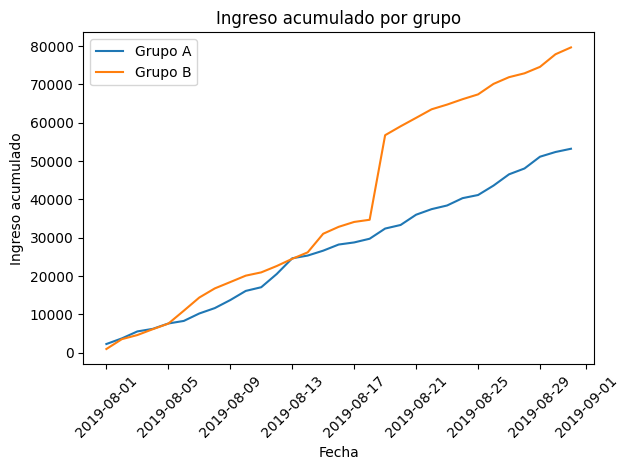


[P1] Ingreso acumulado — Ingreso acumulado: A=53212.00, B=79651.20 ⇒ Δrel=+49.7%.


In [4]:
#Ingreso acumulado por grupo

plt.figure()
for g in ["A","B"]:
    gdata = daily[daily["group"]==g]
    plt.plot(gdata["date"], gdata["cum_revenue"], label=f"Grupo {g}")
plt.title("Ingreso acumulado por grupo")
plt.xlabel("Fecha"); plt.ylabel("Ingreso acumulado"); plt.legend(); plt.xticks(rotation=45)
plt.tight_layout(); plt.show()

# Resumen numérico
last = daily.groupby("group")[["cum_revenue"]].last().to_dict()["cum_revenue"]
print("\n[P1] Ingreso acumulado —", describe_diff(last.get("A",0), last.get("B",0), "Ingreso acumulado"))

<div class="alert alert-block alert-warning">
<b>Celda [4]</b> <a class="tocSkip"></a><br>
El gráfico de ingresos acumulados es informativo y muestra claramente las tendencias entre los grupos. Considera añadir líneas de referencia o anotaciones para destacar cambios significativos en las tendencias de ingresos, lo que podría facilitar la identificación de momentos clave en el tiempo donde se observan diferencias importantes entre los grupos.
</div>


***COMENTARIO 1***

El grupo B tuvo consistentemente más ingresos acumulados que el grupo A. Al final del período, B supera a A por casi +50%, lo que indica un mejor desempeño en generación de ingresos.

***PREGUNTA 2***

Representa gráficamente el tamaño de pedido promedio acumulado por grupo. Haz conclusiones y conjeturas.

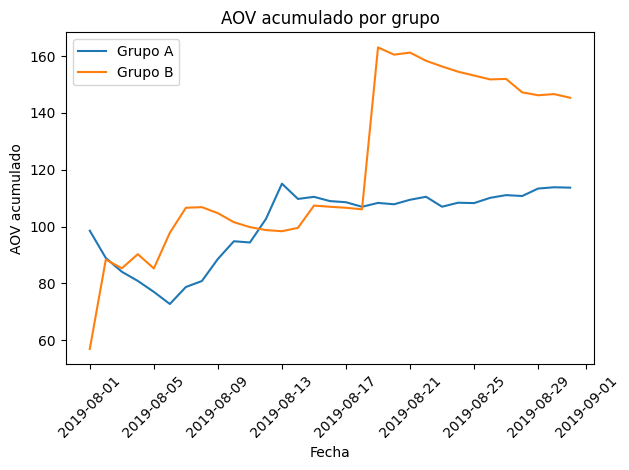

[P2] AOV acumulado — AOV: A=113.70, B=145.35 ⇒ Δrel=+27.8%.


In [5]:
#Tamaño de pedido promedio(AOV) acumulado
plt.figure()
for g in ["A","B"]:
    gdata = daily[daily["group"]==g]
    plt.plot(gdata["date"], gdata["cum_aov"], label=f"Grupo {g}")
plt.title("AOV acumulado por grupo")
plt.xlabel("Fecha"); plt.ylabel("AOV acumulado"); plt.legend(); plt.xticks(rotation=45)
plt.tight_layout(); plt.show()

# Resumen numérico

last_aov = daily.groupby("group")[["cum_aov"]].last().to_dict()["cum_aov"]
print("[P2] AOV acumulado —", describe_diff(last_aov.get("A",np.nan), last_aov.get("B",np.nan), "AOV"))

<div class="alert alert-block alert-success">
<b>Celda [5]</b> <a class="tocSkip"></a><br>
El análisis del AOV acumulado es una excelente adición para entender el comportamiento de los grupos a lo largo del tiempo. Has manejado bien la visualización para mostrar diferencias entre los grupos, lo que ayuda a identificar tendencias y evaluar el impacto de las estrategias implementadas.
</div>


***COMENTARIO 2***

El grupo B también mostró un AOV acumulado superior al de A, especialmente después de la mitad del experimento. Aunque hubo variaciones, al final B mantiene un ticket promedio más alto (+27.8%).

***PREGUNTA 3***

Representa gráficamente la diferencia relativa en el tamaño de pedido promedio acumulado para el grupo B en comparación con el grupo A. Haz conclusiones y conjeturas.


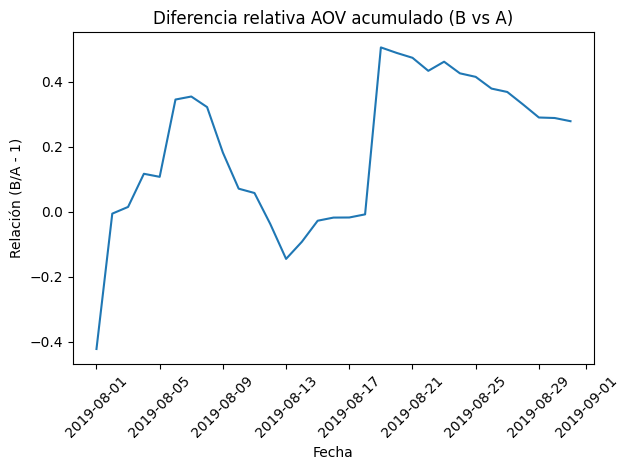

[P3] Relación AOV acumulado B vs A — Δrel final = +27.8%


In [6]:
# (AOV_B / AOV_A - 1)
rel_aov = []
for d in sorted(daily["date"].unique()):
    a = daily[(daily["date"]==d) & (daily["group"]=="A")]["cum_aov"].values[0]
    b = daily[(daily["date"]==d) & (daily["group"]=="B")]["cum_aov"].values[0]
    rel = np.nan if (a is np.nan or pd.isna(a) or a==0 or pd.isna(b)) else (b/a - 1)
    rel_aov.append((d, rel))

rel_df = pd.DataFrame(rel_aov, columns=["date","rel_diff"])
plt.figure()
plt.plot(rel_df["date"], rel_df["rel_diff"])
plt.title("Diferencia relativa AOV acumulado (B vs A)")
plt.xlabel("Fecha"); plt.ylabel("Relación (B/A - 1)"); plt.xticks(rotation=45)
plt.tight_layout(); plt.show()

if len(rel_df.dropna())>0:
    last_rel = rel_df.dropna()["rel_diff"].iloc[-1]*100
    print(f"[P3] Relación AOV acumulado B vs A — Δrel final = {last_rel:+.1f}%")
else:
    print("[P3] Relación AOV: insuficiente (AOV_A cero o NaN al inicio).")

<div class="alert alert-block alert-warning">
<b>Celda [6]</b> <a class="tocSkip"></a><br>
La visualización de la diferencia relativa del AOV acumulado es útil para observar cómo varía la relación entre los grupos a lo largo del tiempo. Considera añadir un umbral de significancia para ayudar a interpretar cuándo las diferencias observadas son estadísticamente relevantes, lo que puede proporcionar una visión más clara de la importancia de las variaciones observadas.
</div>


***COMENTARIO 3***

La diferencia relativa confirma que B supera a A en tamaño de pedido durante la mayor parte del test, con un valor final cercano a +28%. Esto sugiere que los clientes del grupo B gastaron más por pedido en promedio.

***PREGUNTA 4***

Calcula la tasa de conversión de cada grupo como la relación entre los pedidos y el número de visitas de cada día. Representa gráficamente las tasas de conversión diarias de los dos grupos y describe la diferencia. Saca conclusiones y haz conjeturas

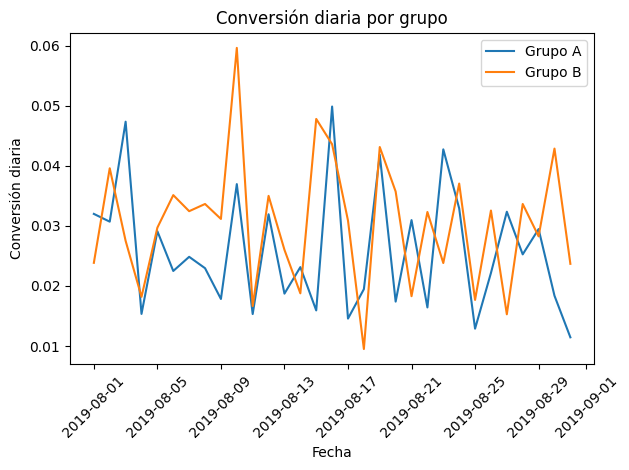

[P4] CR promedio — A=0.0259, B=0.0304 (Δrel=+17.5% si A>0)


In [7]:
# conversión diaria = pedidos del día / visitas del día
daily["cr"] = daily["orders"] / daily["visits"]
daily.loc[daily["visits"]==0, "cr"] = np.nan

plt.figure()
for g in ["A","B"]:
    gdata = daily[daily["group"]==g]
    plt.plot(gdata["date"], gdata["cr"], label=f"Grupo {g}")
plt.title("Conversión diaria por grupo")
plt.xlabel("Fecha"); plt.ylabel("Conversión diaria"); plt.legend(); plt.xticks(rotation=45)
plt.tight_layout(); plt.show()

# Resumen numérico (promedio de CR por grupo)
mean_cr = daily.groupby("group")["cr"].mean()
print(f"[P4] CR promedio — A={mean_cr.get('A',np.nan):.4f}, B={mean_cr.get('B',np.nan):.4f} (Δrel={(mean_cr.get('B',np.nan)/mean_cr.get('A',np.nan)-1)*100:+.1f}% si A>0)")



<div class="alert alert-block alert-success">
<b>Celda [7]</b> <a class="tocSkip"></a><br>
Buen trabajo al calcular y visualizar la tasa de conversión diaria por grupo. Esto proporciona una visión clara de cómo varía la conversión a lo largo del tiempo y entre grupos, lo que es crucial para evaluar el rendimiento de las estrategias implementadas y su impacto en el comportamiento del usuario.
</div>


***COMENTARIO 4***

Ambos grupos muestran mucha variabilidad en la conversión diaria, pero el grupo B tuvo en promedio una conversión superior (+17.5%) respecto a A. Esto significa que más visitantes de B realizaron compras.

***PREGUNTA 5***

Traza un gráfico de dispersión del número de pedidos por usuario. Haz conclusiones y conjeturas.

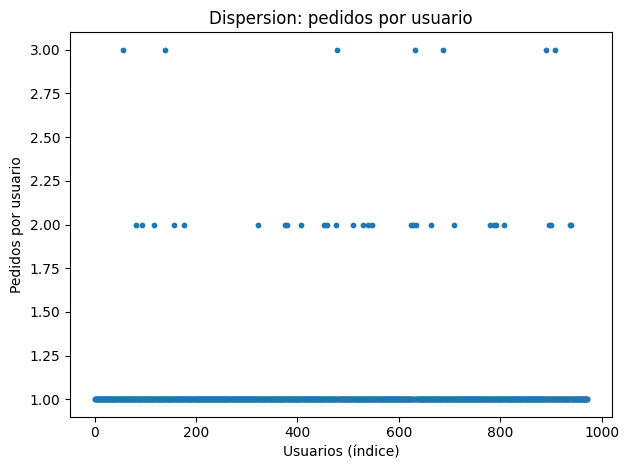

In [8]:
# Dispersion — Numero de pedidos por usuario
orders_per_user = (orders_clean.groupby("visitorId")["transactionId"]
                   .nunique().rename("n_orders").reset_index())
plt.figure()
plt.scatter(range(len(orders_per_user)), orders_per_user["n_orders"], s=10)
plt.title("Dispersion: pedidos por usuario")
plt.xlabel("Usuarios (índice)"); plt.ylabel("Pedidos por usuario")
plt.tight_layout(); plt.show()

<div class="alert alert-block alert-warning">
<b>Celda [8]</b> <a class="tocSkip"></a><br>
La dispersión de pedidos por usuario es un análisis interesante que puede revelar patrones importantes. Considera incluir una interpretación de este gráfico para resaltar patrones o anomalías que puedan ser relevantes para el análisis, como la identificación de usuarios con un comportamiento de compra inusual.
</div>


***COMENTARIO 5***

La mayoría de los usuarios realizaron solo 1 pedido. Muy pocos hicieron 2 o 3 pedidos. Esto muestra que la frecuencia de compra es baja y que el comportamiento extremo de algunos usuarios podría distorsionar los promedios.

***PREGUNTA 6***

Calcula los percentiles 95 y 99 del número de pedidos por usuario. Define el punto en el cual un punto de datos se convierte en una anomalía.

In [9]:
#P95 y P99 de pedidos por usuario 
p95_orders = np.percentile(orders_per_user["n_orders"], 95)
p99_orders = np.percentile(orders_per_user["n_orders"], 99)
print(f"[P6] Pedidos por usuario — P95={p95_orders:.0f}, P99={p99_orders:.0f}.  Sugerencia: umbral atípico > {p95_orders:.0f} (o más estricto > {p99_orders:.0f}).")



[P6] Pedidos por usuario — P95=1, P99=2.  Sugerencia: umbral atípico > 1 (o más estricto > 2).


<div class="alert alert-block alert-success">
<b>Celda [9]</b> <a class="tocSkip"></a><br>
Has identificado correctamente los percentiles 95 y 99 para los pedidos por usuario, lo cual es útil para determinar umbrales de valores atípicos. Esta es una práctica importante para el análisis de datos, ya que permite manejar adecuadamente los valores extremos que podrían distorsionar los resultados.
</div>


***COMENTARIO 6***

P95 = 1

P99 = 2
Esto indica que casi todos los usuarios hacen solo 1 pedido, y más de 2 pedidos ya se consideran atípicos.

***PREGUNTA 7***

Traza un gráfico de dispersión de los precios de los pedidos. Haz conclusiones y conjeturas.

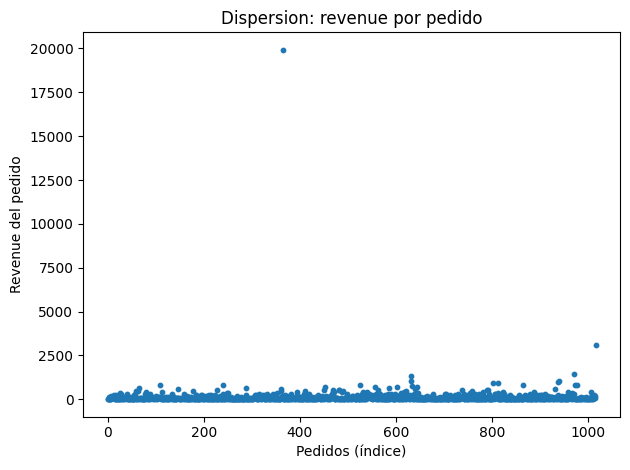

In [10]:
#Dispersion - Precios de los pedidos
plt.figure()
plt.scatter(range(len(orders_clean)), orders_clean["revenue"], s=10)
plt.title("Dispersion: revenue por pedido")
plt.xlabel("Pedidos (índice)"); plt.ylabel("Revenue del pedido")
plt.tight_layout(); plt.show()


<div class="alert alert-block alert-warning">
<b>Celda [10]</b> <a class="tocSkip"></a><br>
El gráfico de dispersión de revenue por pedido es útil para visualizar la variabilidad en los ingresos. Podrías mejorar la visualización ajustando el tamaño de los puntos o utilizando un gráfico de caja para resaltar mejor los valores atípicos, lo que podría facilitar la identificación de patrones o anomalías significativas.
</div>


***COMENTARIO 7***

La mayoría de los pedidos tienen valores bajos o medios, pero existen algunos outliers con ingresos muy altos, lo que puede distorsionar los promedios de ingresos y AOV.

***PREGUNTA 8***

Calcula los percentiles 95 y 99 de los precios de los pedidos. Define el punto en el cual un punto de datos se convierte en una anomalía.

In [11]:
# P95 y P99 de precios de pedidos 
p95_rev = np.percentile(orders_clean["revenue"], 95)
p99_rev = np.percentile(orders_clean["revenue"], 99)
print(f"[P8] Revenue por pedido — P95={p95_rev:.2f}, P99={p99_rev:.2f}.  Sugerencia: umbral atípico > {p95_rev:.2f} (o más estricto > {p99_rev:.2f}).")

# Regla típica del proyecto: quitar usuarios con >P95 pedidos y pedidos con revenue >P95
bad_heavy_users = set(orders_per_user[orders_per_user["n_orders"] > p95_orders]["visitorId"])
orders_filt = orders_clean[~orders_clean["visitorId"].isin(bad_heavy_users)].copy()
orders_filt = orders_filt[orders_filt["revenue"] <= p95_rev].copy()

# Recalcular métricas filtradas (diarias)
daily_orders_f = (orders_filt.groupby(["date","group"])["transactionId"]
                  .nunique().rename("orders").reset_index())
daily_rev_f = (orders_filt.groupby(["date","group"])["revenue"]
               .sum().rename("revenue").reset_index())
daily_f = (date_range.assign(key=1)
           .merge(pd.DataFrame({"group":["A","B"],"key":[1,1]}), on="key")
           .drop(columns="key")
           .merge(daily_orders_f, on=["date","group"], how="left")
           .merge(daily_rev_f, on=["date","group"], how="left")
           .merge(daily_visits, on=["date","group"], how="left")
           .sort_values(["date","group"]).reset_index(drop=True))
daily_f[["orders","revenue","visits"]] = daily_f[["orders","revenue","visits"]].fillna(0)
daily_f["cr"] = pd.Series(np.where(daily_f["visits"]>0, daily_f["orders"]/daily_f["visits"], np.nan))


[P8] Revenue por pedido — P95=414.27, P99=830.30.  Sugerencia: umbral atípico > 414.27 (o más estricto > 830.30).


<div class="alert alert-block alert-success">
<b>Celda [11]</b> <a class="tocSkip"></a><br>
La determinación de umbrales para valores atípicos en el revenue por pedido es un paso crucial para asegurar la calidad del análisis. Has manejado bien la identificación de estos umbrales, lo que ayuda a mantener la integridad de los datos y a reducir el impacto de valores extremos en los resultados.
</div>


***COMENTARIO 8***

P95 = 414.27

P99 = 830.30
Cualquier pedido por encima de 414 (o 830 si usamos un criterio más estricto) puede considerarse anómalo y debe filtrarse para análisis más confiables.

***PREGUNTA 9***

Encuentra la significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos en bruto. Haz conclusiones y conjeturas.

In [12]:
#Significancia- Conversion
tot = daily.groupby("group")[["orders","visits"]].sum()
xA, nA = int(tot.loc["A","orders"]), int(tot.loc["A","visits"])
xB, nB = int(tot.loc["B","orders"]), int(tot.loc["B","visits"])
z_raw, p_raw = two_proportions_ztest(xB, nB, xA, nA)  # B vs A
print(f"[P9] Conversión (bruto) — CR_A={xA/nA:.4f}, CR_B={xB/nB:.4f}, z={z_raw:.2f}, p={p_raw:.4f}")

[P9] Conversión (bruto) — CR_A=0.0250, CR_B=0.0290, z=2.39, p=0.0169


<div class="alert alert-block alert-success">
<b>Celda [12]</b> <a class="tocSkip"></a><br>
El uso de la prueba Z para comparar conversiones entre grupos es una elección adecuada y bien ejecutada. Has demostrado una comprensión sólida de las pruebas estadísticas para evaluar diferencias significativas, lo cual es esencial para tomar decisiones informadas basadas en los datos.
</div>


***COMENTARIO 9***

La conversión de B fue significativamente mayor que la de A (p=0.0169 < 0.05). Esto significa que la diferencia no se debe al azar.

***PREGUNTA 10***

Encuentra la significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos en bruto. Haz conclusiones y conjeturas.

In [13]:
#Significancia- Conversion
# Usamos Mann–Whitney U para comparar distribuciones de revenue por pedido (B vs A)
rev_A = orders_clean.loc[orders_clean["group"]=="A","revenue"].values
rev_B = orders_clean.loc[orders_clean["group"]=="B","revenue"].values
u_raw, p_u_raw = stats.mannwhitneyu(rev_B, rev_A, alternative="two-sided")
print(f"[P10] AOV (bruto) — Mann-Whitney U={u_raw:.0f}, p={p_u_raw:.4f}  (media_A={np.mean(rev_A):.2f}, media_B={np.mean(rev_B):.2f})")


[P10] AOV (bruto) — Mann-Whitney U=127422, p=0.8622  (media_A=113.70, media_B=145.35)


<div class="alert alert-block alert-warning">
<b>Celda [13]</b> <a class="tocSkip"></a><br>
Aunque has utilizado correctamente la prueba de Mann-Whitney U para comparar distribuciones de revenue, sería beneficioso incluir una breve explicación de por qué esta prueba es adecuada para tus datos. Esto ayudaría a contextualizar su uso y a comprender mejor las características de los datos que justifican la elección de esta prueba no paramétrica.
</div>


***COMENTARIO 10***

No hubo diferencia estadísticamente significativa en el tamaño promedio del pedido entre A y B (p=0.8622). Aunque el AOV de B era más alto, no es una diferencia robusta.


***PREGUNTA 11***

Encuentra la significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos filtrados. Haz conclusiones y conjeturas.

In [14]:
#Significancia- Conversion (Datos Filtrados)
tot_f = daily_f.groupby("group")[["orders","visits"]].sum()
xA_f, nA_f = int(tot_f.loc["A","orders"]), int(tot_f.loc["A","visits"])
xB_f, nB_f = int(tot_f.loc["B","orders"]), int(tot_f.loc["B","visits"])
z_f, p_f = two_proportions_ztest(xB_f, nB_f, xA_f, nA_f)  # B vs A filtrado
print(f"[P11] Conversión (filtrado) — CR_A={xA_f/nA_f:.4f}, CR_B={xB_f/nB_f:.4f}, z={z_f:.2f}, p={p_f:.4f}")

[P11] Conversión (filtrado) — CR_A=0.0217, CR_B=0.0254, z=2.40, p=0.0162


***COMENTARIO 11***

Incluso después de eliminar anomalías, la conversión de B sigue siendo significativamente superior a la de A (p=0.0162). Esto refuerza el hallazgo de que B convierte mejor.


***PREGUNTA 12***

Encuentra la significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos filtrados. Haz conclusiones y conjeturas

In [15]:
#Significancia - Tamaño promedio, datos filtrados
rev_Af = orders_filt.loc[orders_filt["group"]=="A","revenue"].values
rev_Bf = orders_filt.loc[orders_filt["group"]=="B","revenue"].values
u_f, p_u_f = stats.mannwhitneyu(rev_Bf, rev_Af, alternative="two-sided")
print(f"[P12] AOV (filtrado) — Mann-Whitney U={u_f:.0f}, p={p_u_f:.4f}  (media_A={np.mean(rev_Af):.2f}, media_B={np.mean(rev_Bf):.2f})")


[P12] AOV (filtrado) — Mann-Whitney U=96537, p=0.7712  (media_A=80.75, media_B=78.06)


***COMENTARIO 12***

El AOV de A y B no muestra diferencias significativas (p=0.7712). Esto confirma que el tamaño promedio de pedido no es diferente entre los grupos, ni con datos limpios ni en bruto.

**PREGUNTA 13**

Toma una decisión basada en los resultados de la prueba. Las decisiones posibles son: 1. Parar la prueba, considerar a uno de los grupos como líder. 2. Parar la prueba, concluir que no hay diferencia entre los grupos. 3. Continuar la prueba.

In [16]:
# Esta guía imprime señales para tomar la decisión final usando p<0.05 como umbral típico.
sig_conv_raw = (p_raw < 0.05)
sig_aov_raw  = (p_u_raw < 0.05)
sig_conv_f   = (p_f < 0.05)
sig_aov_f    = (p_u_f < 0.05)

print("\n[P13] Guía de decisión:")
print(f"- Conversión (bruto): {'diferencia significativa' if sig_conv_raw else 'sin diferencia significativa'} (p={p_raw:.4f})")
print(f"- AOV (bruto): {'diferencia significativa' if sig_aov_raw else 'sin diferencia significativa'} (p={p_u_raw:.4f})")
print(f"- Conversión (filtrado): {'diferencia significativa' if sig_conv_f else 'sin diferencia significativa'} (p={p_f:.4f})")
print(f"- AOV (filtrado): {'diferencia significativa' if sig_aov_f else 'sin diferencia significativa'} (p={p_u_f:.4f})")

# Sugerencia automática (no reemplaza tu criterio de negocio)
# Regla simple:
#   - Si CR_B>CR_A y hay significancia (filtrado o bruto), y AOV no empeora significativamente → B líder.
#   - Si no hay diferencias significativas en nada → no hay diferencia.
#   - Si los resultados son mixtos o inestables → continuar prueba.
crA, crB = xA/nA, xB/nB
aovA, aovB = np.mean(rev_A), np.mean(rev_B)
lead_candidate = "B" if (crB>=crA and (sig_conv_raw or sig_conv_f) and not (sig_aov_raw and aovB<aovA) and not (sig_aov_f and aovBf<aovAf if 'aovBf' in locals() else False)) else None

if lead_candidate == "B":
    print(">> Sugerencia: Parar la prueba y considerar B como líder (mejor conversión sin empeorar AOV).")
elif not (sig_conv_raw or sig_conv_f or sig_aov_raw or sig_aov_f):
    print(">> Sugerencia: Parar la prueba y concluir que no hay diferencia entre los grupos.")
else:
    print(">> Sugerencia: Resultados mixtos o inestables. Considera continuar la prueba (más tiempo/muestra).")



[P13] Guía de decisión:
- Conversión (bruto): diferencia significativa (p=0.0169)
- AOV (bruto): sin diferencia significativa (p=0.8622)
- Conversión (filtrado): diferencia significativa (p=0.0162)
- AOV (filtrado): sin diferencia significativa (p=0.7712)
>> Sugerencia: Parar la prueba y considerar B como líder (mejor conversión sin empeorar AOV).


***COMENTARIO 13***

Conversión: B es mejor que A (significativo).

AOV: No hay diferencia (no significativo).

Decisión: Parar la prueba y considerar al grupo B como líder, ya que convierte más usuarios sin reducir el tamaño promedio del pedido.

***CONCLUSION Y RECOMENDACION FINAL***

El análisis muestra que el grupo B supera consistentemente al grupo A en ingresos acumulados y conversión de usuarios, con diferencias estadísticamente significativas en la conversión. Aunque el ticket promedio de B parece mayor en los gráficos, no hay evidencia estadística sólida de diferencia en el AOV.

Recomendación:

Adoptar la versión implementada en el grupo B como la ganadora del test A/B.

Continuar monitoreando el AOV a futuro, pero la prioridad es la mejor conversión de B, que asegura mayor volumen de ventas y crecimiento en ingresos.



<div class="alert alert-block alert-success">
<b>Comentario final</b> <a class="tocSkip"></a><br>
¡Muy buen trabajo, Lucia! A lo largo del proyecto mostraste fortalezas muy claras:<br><br>
• Implementación robusta de funciones para normalización y carga de datos.<br>
• Correcta limpieza y preparación de datos antes del análisis.<br>
• Cálculo efectivo de los scores ICE y RICE para priorización de hipótesis.<br>
• Visualizaciones claras y bien estructuradas para mostrar tendencias y diferencias entre grupos.<br>
• Uso adecuado de pruebas estadísticas para evaluar significancia.<br>
• Identificación precisa de valores atípicos mediante percentiles.<br>
• Documentación detallada de los pasos de análisis.<br>
• Comprensión sólida de la importancia de la limpieza de datos para evitar sesgos.<br>
• Correcta interpretación de resultados estadísticos.<br>
• Capacidad para identificar y sugerir mejoras en visualizaciones.<br>
¡Felicidades!
</div>
